In [ ]:
from google.colab import drive
import tarfile
import nibabel as nib
import json
import matplotlib.pyplot as plt
import numpy as np
import skimage.metrics
import cv2
import skimage as ski
from skimage import io
from skimage.transform import resize
import random
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Input
from tensorflow.keras import Model
import keras
import os

In [ ]:
# !pip install tarfile
# !pip install nibabel
# !pip install numpy
# !pip install matplotlib
# !pip install opencv-python

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset = open('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/dataset.json')
dataset = json.load(dataset)
img_0 = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_00.nii.gz')
img_0_data = img_0.get_fdata()
label_0 = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_00.nii.gz')
label_0_data = label_0.get_fdata()
dataset

{'description': 'Prostate transitional zone and peripheral zone segmentation',
 'labels': {'0': 'background', '1': 'PZ', '2': 'TZ'},
 'licence': 'CC-BY-SA 4.0',
 'modality': {'0': 'T2', '1': 'ADC'},
 'name': 'PROSTATE',
 'numTest': 16,
 'numTraining': 32,
 'quantitative': [0, 1],
 'reference': 'Radboud University, Nijmegen Medical Centre',
 'relase': '1.0 04/05/2018',
 'tensorImageSize': '4D',
 'test': ['./imagesTs/prostate_08.nii.gz',
  './imagesTs/prostate_22.nii.gz',
  './imagesTs/prostate_30.nii.gz',
  './imagesTs/prostate_45.nii.gz',
  './imagesTs/prostate_26.nii.gz',
  './imagesTs/prostate_36.nii.gz',
  './imagesTs/prostate_12.nii.gz',
  './imagesTs/prostate_33.nii.gz',
  './imagesTs/prostate_09.nii.gz',
  './imagesTs/prostate_05.nii.gz',
  './imagesTs/prostate_23.nii.gz',
  './imagesTs/prostate_19.nii.gz',
  './imagesTs/prostate_15.nii.gz',
  './imagesTs/prostate_11.nii.gz',
  './imagesTs/prostate_03.nii.gz',
  './imagesTs/prostate_27.nii.gz'],
 'training': [{'image': './imagesT

['/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_00.nii.gz', '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_01.nii.gz', '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_02.nii.gz', '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_04.nii.gz', '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_06.nii.gz', '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_07.nii.gz', '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_10.nii.gz', '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_13.nii.gz', '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_14.nii.gz', '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_16.nii.gz', '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_17.nii.gz', '/content

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


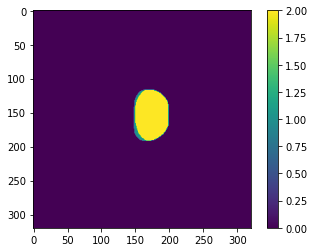

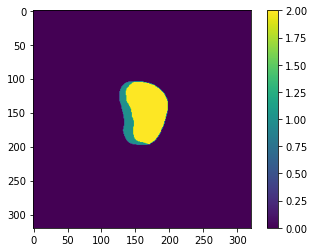

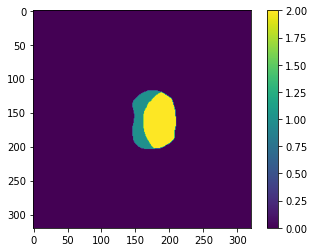

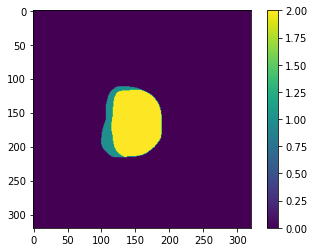

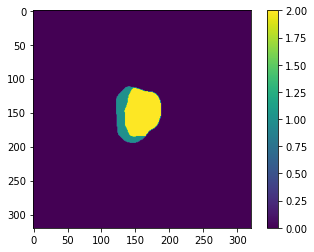

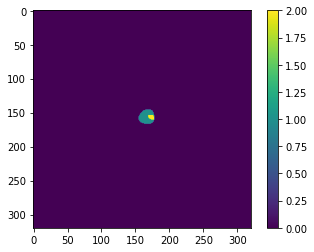

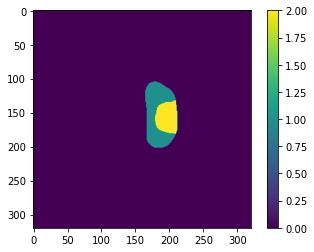

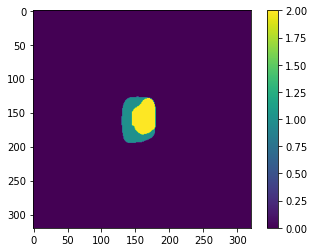

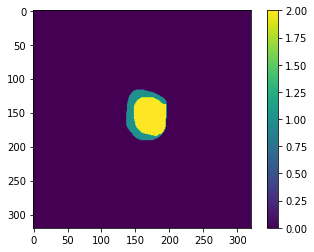

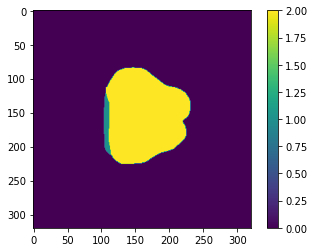

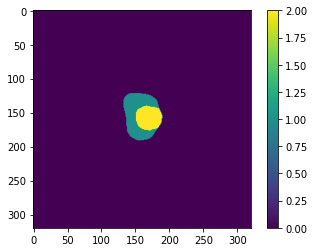

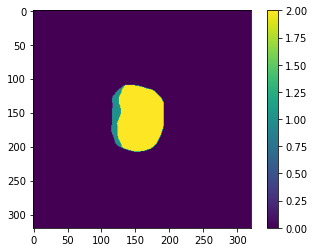

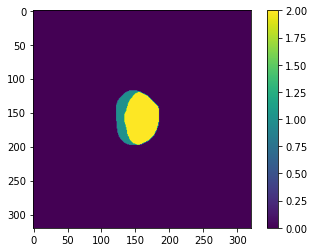

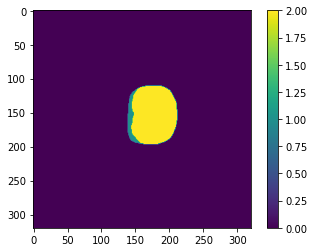

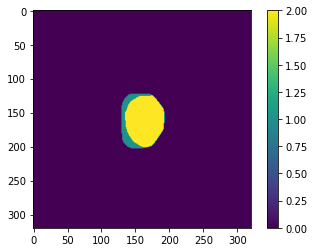

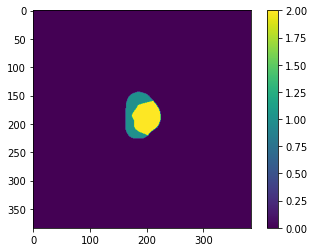

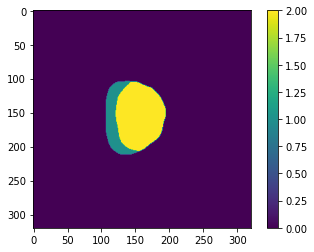

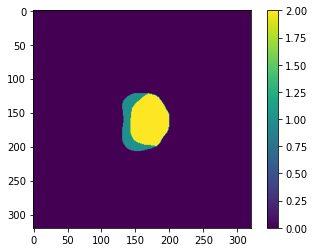

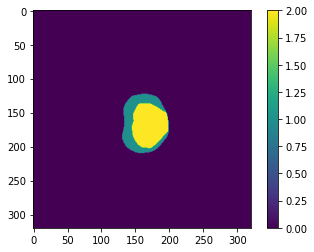

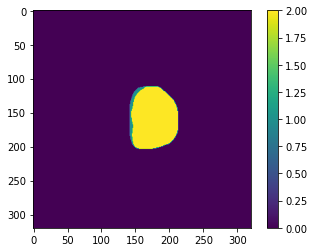

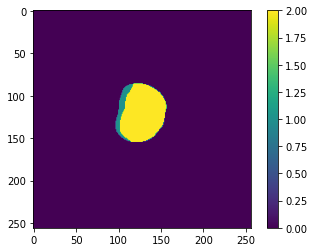

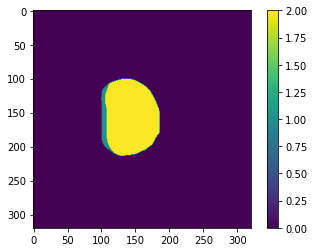

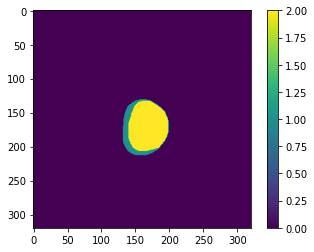

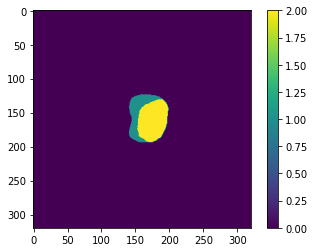

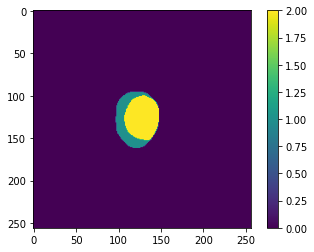

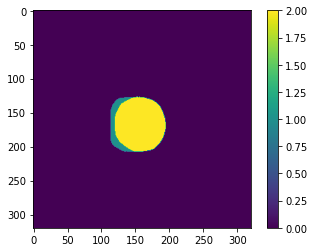

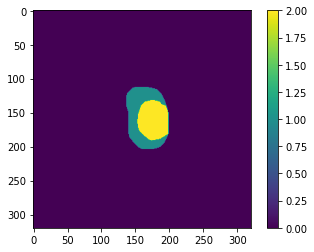

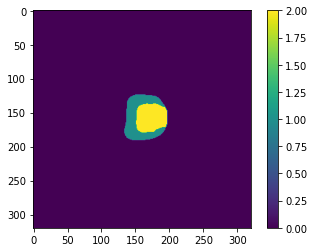

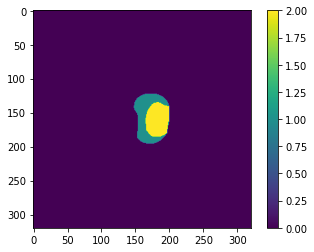

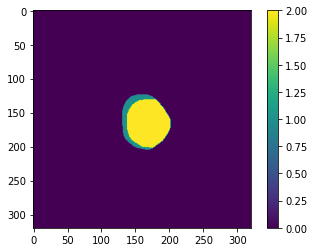

In [ ]:
import glob
data_dir = '/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/'

train_images = sorted(
glob.glob(os.path.join(data_dir, "labelsTr",'prostate_*.nii.gz')))
print(train_images)


for i,path in enumerate(train_images):
  img = nib.load(path).get_fdata()
  if 1 not in img or 2 not in img:  
    print('img:',path,1 in img, 2 in img)
  slices = img.shape[2]//2
  fig = plt.figure(i)
  plt.imshow(img[:,:,slices])
  plt.colorbar()
 

 #files number 18 and 32 are problematic, they only have label 1

### Only to Make sure!

In [ ]:
# print(dataset)
print(img_0)
# print(img_0_data)
# print(img_0_data.shape)
# print(label_0_data.shape)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (320, 320, 15, 2)
affine: 
[[ 6.00000024e-01  2.62617575e-12 -1.18562854e-10 -9.81661072e+01]
 [ 2.62617445e-12  5.74392021e-01  1.15612793e+00 -1.05466660e+02]
 [ 1.77844180e-11 -1.73419178e-01  3.82928014e+00 -3.91753845e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 320 320  15   2   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        0.6       0.6000003 4.0000024 1.        0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_m

### Some Functions for Showing Images

In [ ]:
def show_slices(slices):
  fig, axes = plt.subplots(1, len(slices), figsize=(18,18))
  for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap='gray', origin='lower', aspect='equal')
  plt.tight_layout()

In [ ]:
def show_slice(slice):
  plt.imshow(slice.T, cmap='gray', origin='lower', aspect='equal')
  plt.tight_layout()
  plt.colorbar()

### Running Some Informative Tests!

True


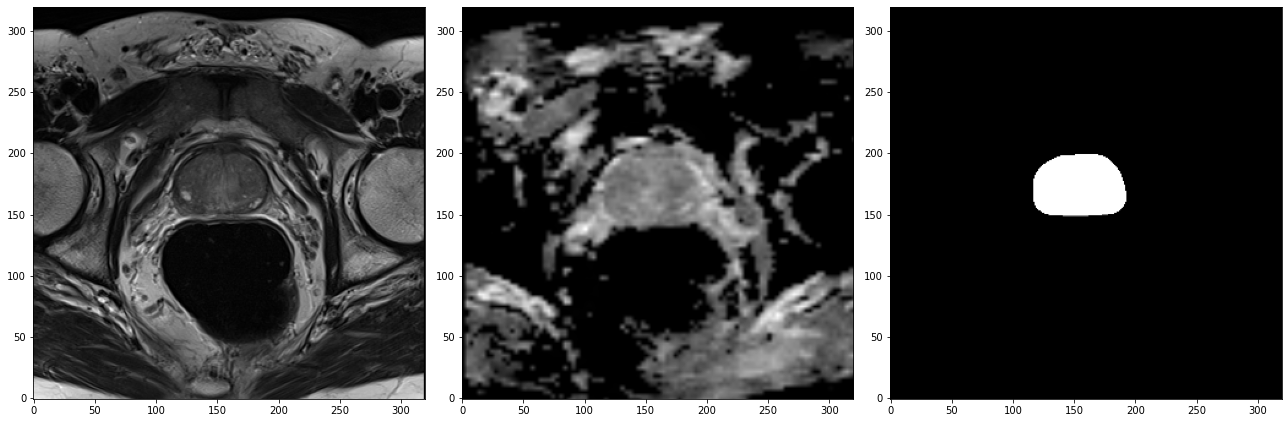

In [ ]:
slice_0 = img_0_data[:, :, 8, 0]
slice_1 = img_0_data[:, :, 8, 1]
slice_2 = label_0_data[:, :, 8]
slice_list = [slice_0, slice_1, slice_2]
print((1 in slice_2 or 2 in slice_2))
show_slices(slice_list)

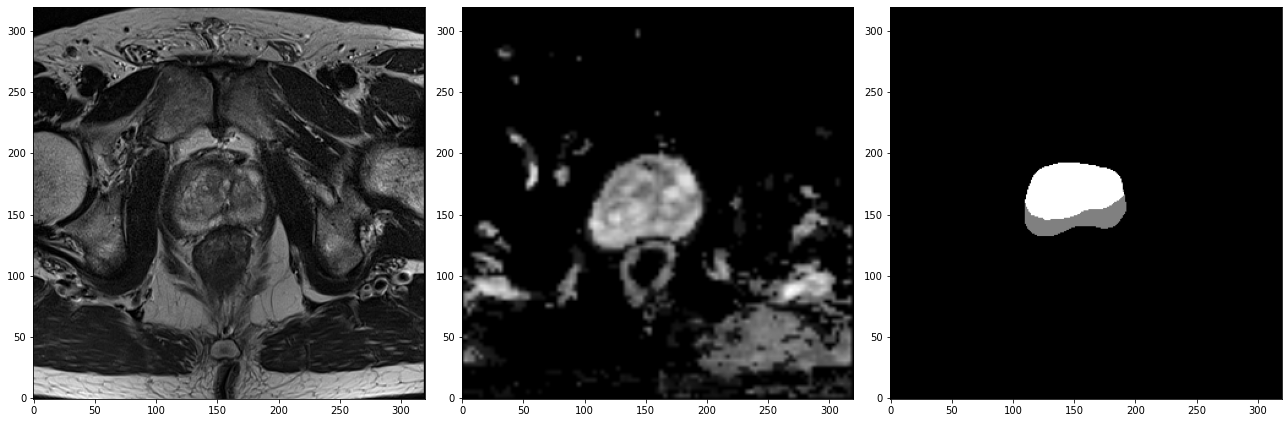

In [ ]:
img_1 = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_01.nii.gz')
label_1 = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_01.nii.gz')
img_1_data = img_1.get_fdata()
label_1_data = label_1.get_fdata()

slice_0 = img_1_data[:, :, 7, 0]
slice_1 = img_1_data[:, :, 7, 1]
slice_2 = label_1_data[:, :, 7]
slice_list = [slice_0, slice_1, slice_2]
show_slices(slice_list)

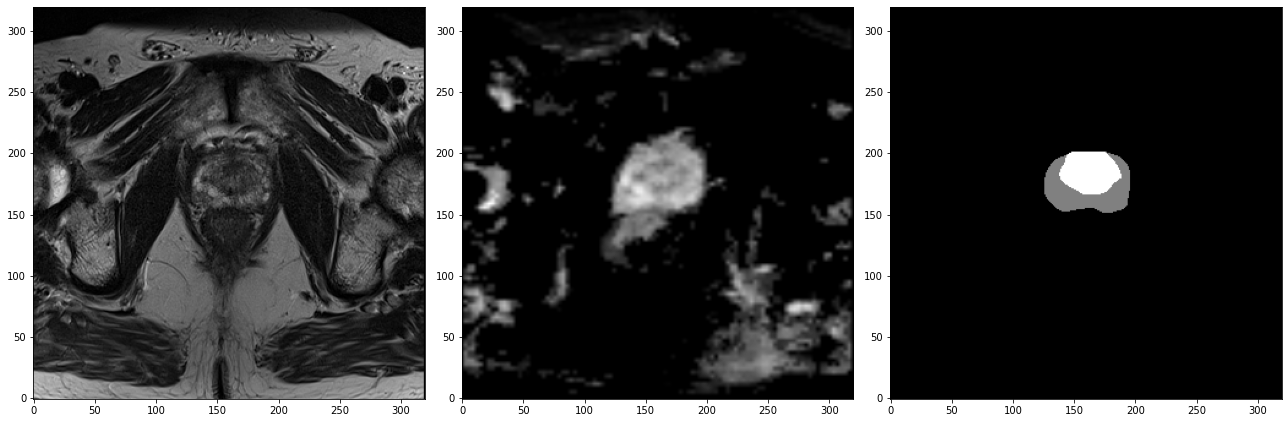

In [ ]:
img_2 = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_02.nii.gz')
label_2 = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_02.nii.gz')
img_2_data = img_2.get_fdata()
label_2_data = label_2.get_fdata()

slice_0 = img_2_data[:, :, 7, 0]
slice_1 = img_2_data[:, :, 7, 1]
slice_2 = label_2_data[:, :, 7]
slice_list = [slice_0, slice_1, slice_2]
show_slices(slice_list)

# **Trying to Make a Heatmap out of a Specific Slice and a Specific Protocol**
The Problematic photos are 18,28,37,41 --- resolutions are different (256x256 and 384x384)

## **First step**: Chosing a list of all available data based on a Slice and Label



In [ ]:
def slice_selector(nslice = 7, nlabel = 2):
  first_one = True
  flag = False
  for i in range(0,50):
    num = str(i)
    if len(num) == 1:
      num = "0" + num
    try:
      img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_'+num+'.nii.gz')
      img_data = img.get_fdata()[:,:,nslice]
      for p in range(img_data.shape[0]):
        for q in range(len(img_data[p])):
          if int(img_data[p,q]) != nlabel:
            img_data[p,q] = float(0)
      img_data = np.array([img_data])
      if first_one:
        img_datas = np.array(img_data)
        first_one = False
      else:
        img_datas = np.append(img_datas, img_data,axis=0)
      flag = True
    except:
      # print("Error with Label No. "+num)
      pass
  if not flag:
    print('Invalid Slice or Protocol')
    return False
  return img_datas

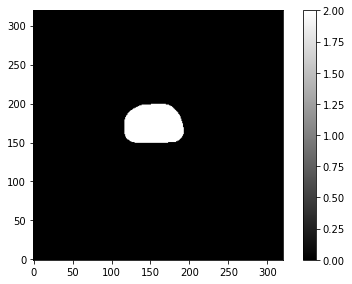

In [ ]:
chosen_slice = slice_selector(nslice = 8, nlabel = 2)
try:
  show_slice(chosen_slice[0,:,:])
except:
  print("Something went wrong, here is the chosen_slice.shape: " + str(chosen_slice.shape))

## **Second Step**: Applying a Heatmap to a Series of Slices on a specific Protocol

In [ ]:
def slices_to_heatmap(chosen_slice):
  final_data = chosen_slice[0,:,:]
  for i in range(1,chosen_slice.shape[0]):
    final_data += chosen_slice[i,:,:]
  final_data /= chosen_slice.shape[0]
  return final_data

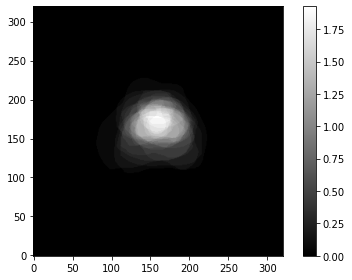

In [ ]:
final_heatmap = slices_to_heatmap(chosen_slice)
show_slice(final_heatmap)

#### Just Cheking the Availability of Files + Their Shape

In [ ]:
for i in range(0,50):
    num = str(i)
    if len(num) == 1:
      num = "0" + num
    try:
      img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_'+num+'.nii.gz')
      img_data = img.get_fdata()
      print(i, img_data.shape)
    except:
      print('No Such File')

0 (320, 320, 15)
1 (320, 320, 20)
2 (320, 320, 24)
No Such File
4 (320, 320, 15)
No Such File
6 (320, 320, 20)
7 (320, 320, 20)
No Such File
No Such File
10 (320, 320, 20)
No Such File
No Such File
13 (320, 320, 20)
14 (320, 320, 20)
No Such File
16 (320, 320, 20)
17 (320, 320, 20)
No Such File
No Such File
20 (320, 320, 20)
21 (320, 320, 20)
No Such File
No Such File
24 (320, 320, 20)
25 (320, 320, 19)
No Such File
No Such File
28 (384, 384, 11)
29 (320, 320, 15)
No Such File
31 (320, 320, 20)
No Such File
No Such File
34 (320, 320, 15)
35 (320, 320, 20)
No Such File
37 (256, 256, 15)
38 (320, 320, 20)
39 (320, 320, 15)
40 (320, 320, 20)
41 (256, 256, 18)
42 (320, 320, 22)
43 (320, 320, 20)
44 (320, 320, 20)
No Such File
46 (320, 320, 20)
47 (320, 320, 20)
No Such File
No Such File


# **Trying to Make a Histogram of ImagesTr**

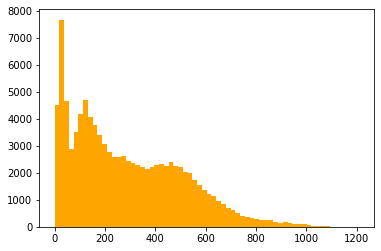

In [ ]:

def plot_hist(nslice,nprotocol, bins=2**8):
  img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_00.nii.gz')
  img = img.get_fdata()[:,:,nslice,nprotocol]
  img = img.ravel()
  all_img_data = img
  for i in range(1,50):
    num = str(i)
    if len(num) == 1:
      num = '0' + num
    try:
      img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_'+num+'.nii.gz')
      img = img.get_fdata()[:,:,nslice,nprotocol]
      img = img.ravel()
      np.append(all_img_data,img)
    except:
      # print('Error No. '+num)
      pass
  # rmin = np.amin(all_img_data)
  # rmax = np.amax(all_img_data)
  plt.hist(all_img_data, bins=bins, color='orange')
  plt.show()
  return 
  
plot_hist(8,0,64)

# Categorize



In [ ]:
def Boundry(lab):
  for slices in range(lab.get_fdata().shape[2]):
    if 1 in lab.get_fdata()[:,:,slices] or 2 in lab.get_fdata()[:,:,slices]:
      lower_limit = slices//2
      break
  for slices in range(lab.get_fdata().shape[2]-1,-1,-1):
    if 1 in lab.get_fdata()[:,:,slices] or 2 in lab.get_fdata()[:,:,slices]:
      upper_limit = (slices + lab.get_fdata().shape[2]-1)//2
      break
  return (lower_limit, upper_limit)

In [ ]:
def Categorize():
  for images in range(50):
    im_num = str(images)
    if len(im_num) == 1:
      im_num = '0' + im_num
    try:
      im = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_{0}.nii.gz'.format(im_num))
      lab = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_{0}.nii.gz'.format(im_num))
      lower_limit, upper_limit = Boundry(lab)
      for slices in range(lower_limit, upper_limit+1):
        im_temp0 = im.get_fdata()[:,:,slices,0]
        im_temp0 = ski.transform.resize(im_temp0, (256,256))
        im_temp1 = im.get_fdata()[:,:,slices,1]
        im_temp1 = ski.transform.resize(im_temp1, (256,256))
        lab_temp = lab.get_fdata()[:,:,slices]
        lab_temp = ski.transform.resize(lab_temp, (256,256))
        slice_num = str(slices)
        if len(slice_num) == 1:
          slice_num = '0' + slice_num
        np.savez('/content/gdrive/My Drive/AI-Medic/Prostate/Data/Image_{0}_Slice_{1}.npz'.format(im_num, slice_num), img_modality_0=im_temp0, img_modality_1=im_temp1, mask=lab_temp)
    except:
      pass

In [ ]:
# Categorize()

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


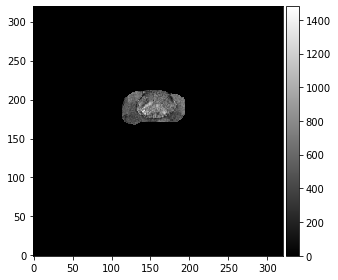

In [ ]:
im = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_10.nii.gz')
lab = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_10.nii.gz')
im = im.get_fdata()[:,:,8,0]
lab = lab.get_fdata()[:,:,8]
res = np.multiply(im,lab)
ski.io.imshow(res.T, origin='lower', cmap='gray')

In [ ]:
# npzfiles = np.load('/content/gdrive/My Drive/AI-Medic/Prostate/Data/Image_06_Slice_08.npz')

FileNotFoundError: ignored

In [ ]:
# npzfiles.files

## **Cumulative Histogram**

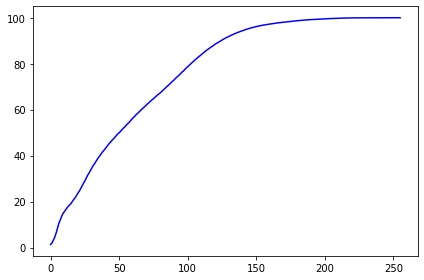

In [ ]:
def plot_cum_hist(nslice, nprotocol, bins=2**8):
  img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_00.nii.gz')
  img = img.get_fdata()[:,:,nslice,nprotocol]
  img = img.ravel()
  all_img_data = img
  for i in range(1,50):
    num = str(i)
    if len(num) == 1:
      num = '0' + num
    try:
      img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_'+num+'.nii.gz')
      img = img.get_fdata()[:,:,nslice,nprotocol]
      img = img.ravel()
      np.append(all_img_data,img)
    except:
      # print('Error No. '+num)
      pass
  rmin = np.amin(all_img_data)
  rmax = np.amax(all_img_data)
  occ = np.zeros(bins, dtype='int16')
  chunk = (int(rmax-rmin)+1)/bins
  for i in all_img_data:
    occ[int(i/chunk)] += 1
  occ_cum = np.array([])
  total = sum(occ)
  for i in range(1,bins+1):
     occ_cum = np.append(occ_cum, [(sum(occ[:i])/total)*100])

  tick_label = np.array([int(rmin)])
  for i in range(bins,1,-1):
    tick_label = np.append(tick_label, int(rmax)//i)
  plt.plot(range(bins), occ_cum, color='blue')
  plt.tight_layout()
  plt.show()
  return

plot_cum_hist(nslice = 8, nprotocol = 0, bins = 256)

In [ ]:
def POW(img, power = 1.5):
  # if img.dtype != 'uint8':
  #   img /= np.max(img)
  #   img *= 255
  #   img = img.astype('uint8')
  img_powered = np.power(img, power)
  return img_powered

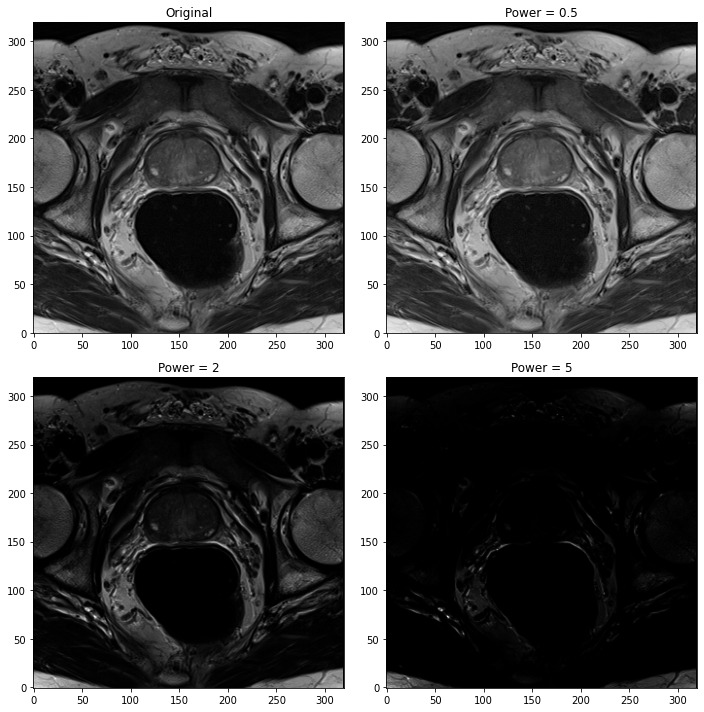

In [ ]:
img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_00.nii.gz').get_fdata()[:,:,8,0]
img = img.T
# img /= np.max(img)
# img *= 255
# img = img.astype('uint8')

fig, axes = plt.subplots(2,2, figsize=(10,10))
axes[0,0].imshow(img, cmap='gray', origin='lower')
axes[0,0].set_title('Original')
axes[0,1].imshow(POW(img, power = 0.8), cmap='gray', origin='lower')
axes[0,1].set_title('Power = 0.5')
axes[1,0].imshow(POW(img, power = 2), cmap='gray', origin='lower')
axes[1,0].set_title('Power = 2')
axes[1,1].imshow(POW(img, power = 5), cmap='gray', origin='lower')
axes[1,1].set_title('Power = 5')
plt.tight_layout()
# print('PSNR for Power = 1.5: ',round(skimage.metrics.peak_signal_noise_ratio(img, POW(img, power = 1.5)),2))
# print('PSNR for Power = 3: ',round(skimage.metrics.peak_signal_noise_ratio(img, POW(img, power = 3)),2))
# print('PSNR for Power = 5: ',round(skimage.metrics.peak_signal_noise_ratio(img, POW(img, power = 5)),2))

In [ ]:
def CLAHE(img, clip_limit=2,tile_grid_size=(8,8)):
  if img.dtype != 'uint8':
    img /= img.max()
    img *= 255 #lazem nist
    img = img.astype('uint8') #lazem nist
  # img = cv2.imread(img, cv2.IMREAD_ANYDEPTH)
  img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
  l,a,b = cv2.split(img_lab)
  # plt.hist(l.flat, bins=100, range=(0,255))
  equ = cv2.equalizeHist(l)
  # plt.hist(equ.flat, bins=100, range=(0,255))
  # plt.imshow(equ, cmap='gray')

  updated_lab_img = cv2.merge((equ,a,b))
  # plt.imshow(updated_lab_img, cmap='gray')
  hist_eq_img = cv2.cvtColor(updated_lab_img, cv2.COLOR_LAB2BGR)
  # plt.imshow(hist_eq_img, cmap='gray')

  clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
  clahe_img = clahe.apply(l)
  updated_lab_img_2 = cv2.merge((clahe_img, a,b))
  CLAHE_img = cv2.cvtColor(updated_lab_img_2, cv2.COLOR_LAB2BGR)
  CLAHE_img = cv2.cvtColor(CLAHE_img, cv2.COLOR_BGR2GRAY)
  return CLAHE_img


PSNR for Clip Limit=2:  19.08
PSNR for Clip Limit=10:  12.02
PSNR for No Clip Limit:  10.51


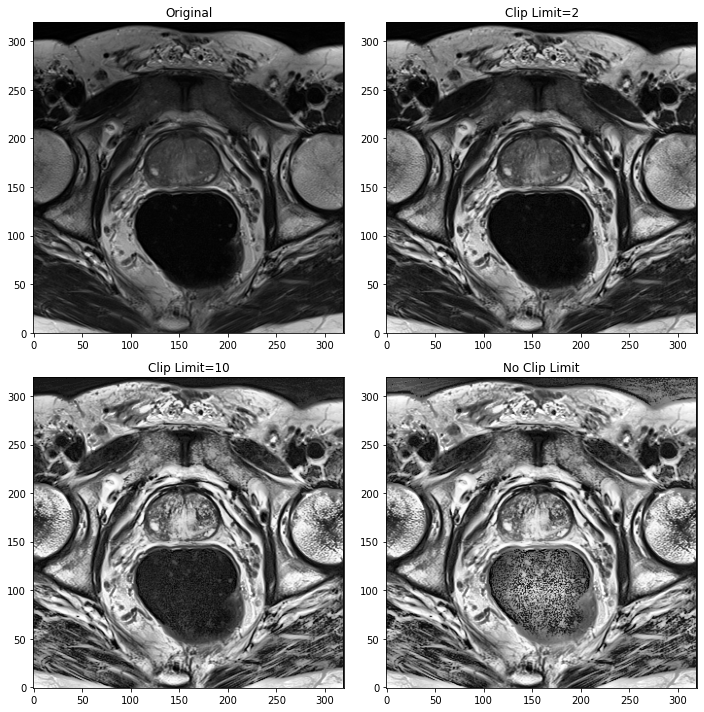

In [ ]:
img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_00.nii.gz')
img = img.get_fdata()[:,:,8,0]
img = img.T
img /= np.max(img)
img *= 255
img = img.astype('uint8') 

fig, axes = plt.subplots(2,2, figsize=(10,10))
axes[0,0].imshow(img, cmap='gray', origin='lower')
axes[0,0].set_title('Original')
axes[0,1].imshow(CLAHE(img, clip_limit=1.5), cmap='gray', origin='lower')
axes[0,1].set_title('Clip Limit=2')
axes[1,0].imshow(CLAHE(img, clip_limit=10), cmap='gray', origin='lower')
axes[1,0].set_title('Clip Limit=10')
axes[1,1].imshow(CLAHE(img, clip_limit=9999), cmap='gray', origin='lower')
axes[1,1].set_title('No Clip Limit')
plt.tight_layout()
print('PSNR for Clip Limit=2: ',round(skimage.metrics.peak_signal_noise_ratio(img, CLAHE(img, clip_limit=1.5)),2))
print('PSNR for Clip Limit=10: ',round(skimage.metrics.peak_signal_noise_ratio(img, CLAHE(img, clip_limit=10)),2))
print('PSNR for No Clip Limit: ',round(skimage.metrics.peak_signal_noise_ratio(img, CLAHE(img, clip_limit=9999)),2))

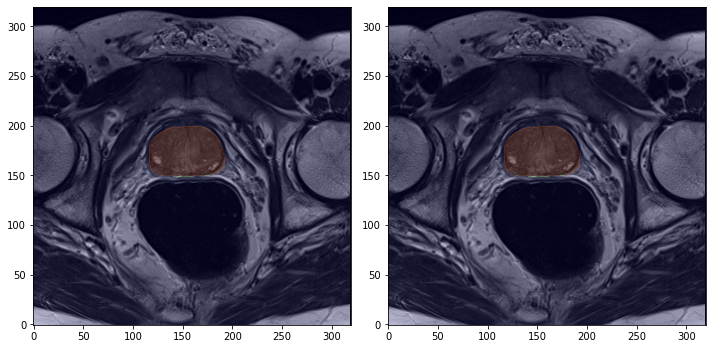

In [ ]:
img_number = "00"
slice_number = 8
img_1 = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_{0}.nii.gz'.format(img_number)).get_fdata()[:,:,slice_number,0]
img_2 = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_{0}.nii.gz'.format(img_number)).get_fdata()[:,:,slice_number]
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(img_1.T,origin='lower',cmap='gray')
ax[0].imshow(img_2.T, origin='lower',cmap='jet', alpha=0.2)
ax[1].imshow(img_1.T,origin='lower',cmap='gray')
ax[1].imshow(img_2.T, origin='lower',cmap='jet', alpha=0.2)
plt.tight_layout()

In [ ]:
def Data_Distribution(mode):
  if mode == "depth":
    max_slice_number = 0
    for images in range(50):
      im_num = str(images)
      if len(im_num) == 1:
        im_num = '0' + im_num
      try:
        slice_number = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_{0}.nii.gz'.format(im_num)).get_fdata().shape[2]
        if max_slice_number < slice_number:
          max_slice_number = slice_number
      except:
        pass
    black_masks = np.zeros(max_slice_number, dtype='int8')
    for images in range(50):
      im_num = str(images)
      if len(im_num) == 1:
        im_num = '0' + im_num
      try:
        lab = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_{0}.nii.gz'.format(im_num))
        for slices in range(lab.get_fdata().shape[2]):
          if 1 not in lab.get_fdata()[:,:,slices] and 2 not in lab.get_fdata()[:,:,slices]:
            black_masks[slices] += 1
      except:
        pass
    return black_masks
  if mode == "width":
    # max_slice_number = 0
    # for images in range(50):
    #   im_num = str(images)
    #   if len(im_num) == 1:
    #     im_num = '0' + im_num
    #   try:
    #     slice_number = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_{0}.nii.gz'.format(im_num)).get_fdata().shape[0]
    #     if max_slice_number < slice_number:
    #       max_slice_number = slice_number
    #   except:
    #     pass
    black_masks = np.zeros(256, dtype='int8')
    for images in range(50):
      im_num = str(images)
      if len(im_num) == 1:
        im_num = '0' + im_num
      try:
        lab = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_{0}.nii.gz'.format(im_num))
        lab = lab.get_fdata()
        lab = ski.transform.resize(lab, (256,256))
        for slices in range(lab.shape[0]):
          if 1 not in lab[slices,:,:] and 2 not in lab[slices,:,:]:
            black_masks[slices] += 1
      except:
        pass
    return black_masks

In [ ]:
depth_black_masks = Data_Distribution('depth')
width_black_masks = Data_Distribution('width')

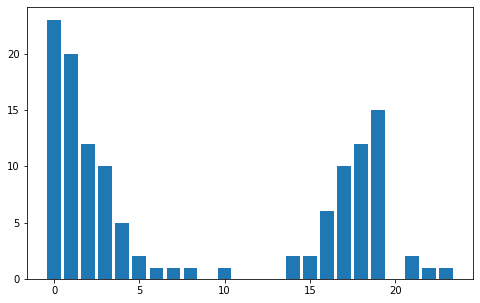

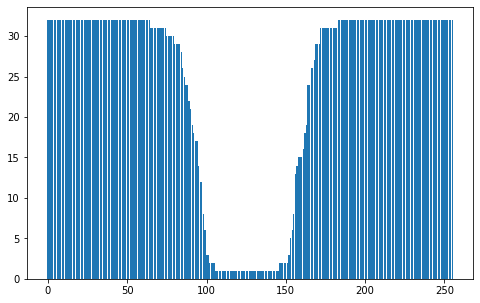

In [ ]:
plot_1 = plt.figure(1, figsize=(8,5))
plt.bar(range(len(depth_black_masks)),depth_black_masks)
plot_1 = plt.figure(2, figsize=(8,5))
plt.bar(range(len(width_black_masks)),width_black_masks)
plt.show()

In [ ]:
def BCET(img, output_min=0, output_max = 255, output_mean=110):
  if img.dtype != 'uint8':
    img /= np.max(img)
    img *= 255
    img = img.astype('uint8')
  input_min = np.min(img)
  input_max = np.max(img)
  input_mean = np.mean(img)
  input_mean_sqr = np.mean(img**2)
  output_min = output_min
  output_max = output_max
  output_mean = output_mean
  b = (input_max**2 * (output_mean-output_min) - input_mean_sqr*(output_max - output_min) + input_min**2 * (output_max - output_mean)) / (2*(input_max*(output_mean - output_min) - input_mean*(output_max - output_min) + input_min*(output_max - output_mean)))
  a = (output_max - output_min)/((input_max - input_min)*(input_max - input_min - 2*b))
  c = output_min - a*(input_min - b)**2
  output_img = a*(img-b)**2 + c
  output_img /= np.max(output_img)
  output_img *= 255
  output_img = output_img.astype('uint8')
  return output_img


PSNR for output_mean = 50:  30.46
PSNR for output_mean = 125:  14.86
PSNR for output_mean = 200:  10.94


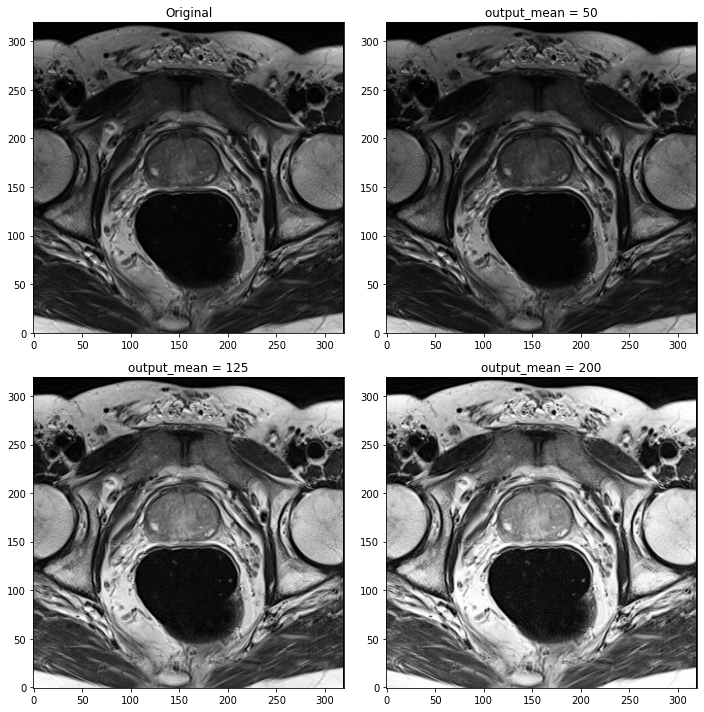

In [ ]:
img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_00.nii.gz').get_fdata()[:,:,8,0]
img = img.T
img /= np.max(img)
img *= 255
img = img.astype('uint8')
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes[0,0].imshow(img, cmap='gray', origin='lower')
axes[0,0].set_title('Original')
axes[0,1].imshow(BCET(img, output_mean = 50), cmap='gray', origin='lower')
axes[0,1].set_title('output_mean = 50')
axes[1,0].imshow(BCET(img, output_mean = 125), cmap='gray', origin='lower')
axes[1,0].set_title('output_mean = 125')
axes[1,1].imshow(BCET(img, output_mean = 200), cmap='gray', origin='lower')
axes[1,1].set_title('output_mean = 200')
plt.tight_layout()
print('PSNR for output_mean = 50: ',round(skimage.metrics.peak_signal_noise_ratio(img, BCET(img, output_mean = 50)),2))
print('PSNR for output_mean = 125: ',round(skimage.metrics.peak_signal_noise_ratio(img, BCET(img, output_mean = 125)),2))
print('PSNR for output_mean = 200: ',round(skimage.metrics.peak_signal_noise_ratio(img, BCET(img, output_mean = 200)),2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


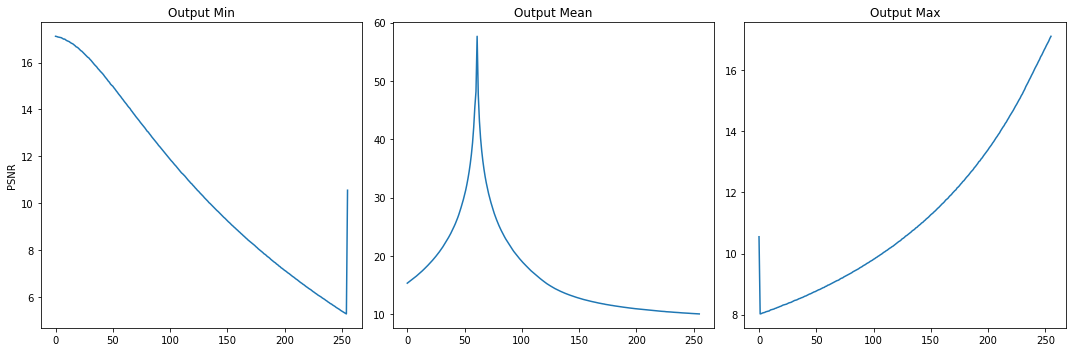

In [ ]:
img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_00.nii.gz')
img = img.get_fdata()[:,:,8,0]
img = img.T
img /= np.max(img)
img *= 255
img = img.astype('uint8')

psnr_values_for_bcet_output_mean = np.zeros(256)
for output_mean in range(256):
  psnr_values_for_bcet_output_mean[output_mean] = round(skimage.metrics.peak_signal_noise_ratio(img, BCET(img, output_mean = output_mean)),2)

psnr_values_for_bcet_output_min = np.zeros(256)
for output_min in range(256):
  psnr_values_for_bcet_output_min[output_min] = round(skimage.metrics.peak_signal_noise_ratio(img, BCET(img, output_min = output_min)),2)

psnr_values_for_bcet_output_max = np.zeros(256)
for output_max in range(256):
  psnr_values_for_bcet_output_max[output_max] = round(skimage.metrics.peak_signal_noise_ratio(img, BCET(img, output_max = output_max)),2)


fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot(psnr_values_for_bcet_output_min)
axes[0].set_title('Output Min')
axes[0].set_ylabel('PSNR')
axes[1].plot(psnr_values_for_bcet_output_mean)
axes[1].set_title('Output Mean')
axes[2].plot(psnr_values_for_bcet_output_max)
axes[2].set_title('Output Max')
plt.tight_layout()

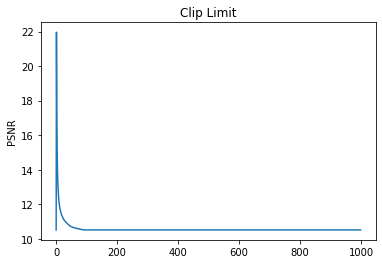

In [ ]:
img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_00.nii.gz')
img = img.get_fdata()[:,:,8,0]
img = img.T
img /= np.max(img)
img *= 255
img = img.astype('uint8')

psnr_values_for_clip_limit = np.zeros(999)
for clip_limit in range(999):
  psnr_values_for_clip_limit[clip_limit] = round(skimage.metrics.peak_signal_noise_ratio(img, CLAHE(img, clip_limit=clip_limit)),2)

plt.plot(psnr_values_for_clip_limit)
plt.title('Clip Limit')
plt.ylabel('PSNR')
plt.show()

PSNR for CLAHE of BCET:  15.04
PSNR for BCET of CLAHE:  14.11


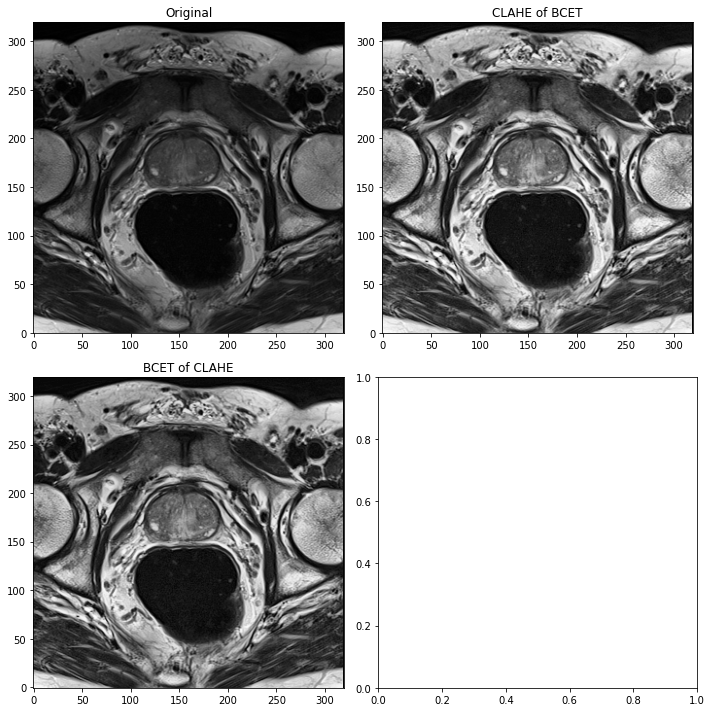

In [ ]:
img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_00.nii.gz')
img = img.get_fdata()[:,:,8,0]
img = img.T
img /= np.max(img)
img *= 255
img = img.astype('uint8')

fig, axes = plt.subplots(2,2, figsize=(10,10))
axes[0,0].imshow(img, cmap='gray', origin='lower')
axes[0,0].set_title('Original')
axes[0,1].imshow(CLAHE(BCET(img)), cmap='gray', origin='lower')
axes[0,1].set_title('CLAHE of BCET')
axes[1,0].imshow(BCET(CLAHE(img)), cmap='gray', origin='lower')
axes[1,0].set_title('BCET of CLAHE')
plt.tight_layout()
print('PSNR for CLAHE of BCET: ',round(skimage.metrics.peak_signal_noise_ratio(img, BCET(CLAHE(img))),2))
print('PSNR for BCET of CLAHE: ',round(skimage.metrics.peak_signal_noise_ratio(img, CLAHE(BCET(img))),2))

In [ ]:
def window(img):
  img = np.clip(img.copy(), -100, 800)
  img = img - np.min(img)
  img = img/np.max(img)
  return img


In [ ]:
def black_range(img):
  for slices in range(img.shape[2]):
    img_slice = img[:,:,slices]
    if 1 in img_slice or 2 in img_slice:
      lower = slices//2
      break
  for slices in range(img.shape[2]-1,-1,-1):
    img_slice = img[:,:,slices]
    if 1 in img_slice or 2 in img_slice:
      upper = (slices + img.shape[2])//2
      break

  return lower, upper

(320, 320, 20)
1 18


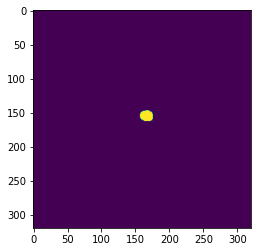

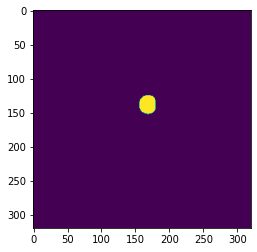

In [ ]:
im_num = 1
im = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_'+str(im_num).zfill(2)+'.nii.gz').get_fdata()
lab = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_'+str(im_num).zfill(2)+'.nii.gz').get_fdata()
print(lab.shape)
lower, upper = black_range(lab)
print(lower, upper)
fig1 = plt.figure(1)
plt.imshow(lab[:,:,lower+1])
fig2 = plt.figure(2)
plt.imshow(lab[:,:,upper-1])

In [ ]:
def Save_train():
  for images in range(50):
    if images == 18 or images == 32:
      continue
    try:
      img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_'+str(images).zfill(2)+'.nii.gz').get_fdata()
      lab = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_'+str(images).zfill(2)+'.nii.gz').get_fdata()
      lower, upper = black_range(lab)
      for slices in range(lower,upper+1):
        im_temp0 = img[:,:,slices,0]
        im_temp0 = cv2.resize(im_temp0, (256,256), interpolation=cv2.INTER_NEAREST)
        im_temp0 = window(im_temp0)
        im_temp1 = img[:,:,slices,1]
        im_temp1 = cv2.resize(im_temp1, (256,256), interpolation=cv2.INTER_NEAREST)
        lab_temp = lab[:,:,slices]
        lab_temp = cv2.resize(lab_temp, (256,256), interpolation=cv2.INTER_NEAREST)
        np.savez_compressed('/content/gdrive/My Drive/AI-Medic/Prostate/Data_Train/Image_'+str(images).zfill(2)+'_Slice_'+str(slices).zfill(2)+'.npz', img_0=im_temp0, img_1=im_temp1, mask=lab_temp)
      print('Train', images)
    except:
      print('nashod', images)
      pass

In [ ]:
Save_train()

Train 0
Train 1
Train 2
nashod 3
Train 4
nashod 5
Train 6
Train 7
nashod 8
nashod 9
Train 10
nashod 11
nashod 12
Train 13
Train 14
nashod 15
Train 16
Train 17
nashod 19
Train 20
Train 21
nashod 22
nashod 23
Train 24
Train 25
nashod 26
nashod 27
Train 28
Train 29
nashod 30
Train 31
nashod 33
Train 34
Train 35
nashod 36
Train 37
Train 38
Train 39
Train 40
Train 41
Train 42
Train 43
Train 44
nashod 45
Train 46
Train 47
nashod 48
nashod 49


In [ ]:
def Save_test():
  for images in range(50):
    try:
      img = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTs/prostate_'+str(images).zfill(2)+'.nii.gz').get_fdata()
      for slices in range(img.shape[2]):
        im_temp0 = img[:,:,slices,0]
        im_temp0 = cv2.resize(im_temp0, (256,256), interpolation=cv2.INTER_NEAREST)
        im_temp1 = img[:,:,slices,1]
        im_temp1 = cv2.resize(im_temp1, (256,256), interpolation=cv2.INTER_NEAREST)
        np.savez_compressed('/content/gdrive/My Drive/AI-Medic/Prostate/Data_Test/Image_'+str(images).zfill(2)+'_Slice_'+str(slices).zfill(2)+'.npz', img_0=im_temp0, img_1=im_temp1)
      print('Test', images)
    except:
      print('nashod', images)
      pass

In [ ]:
# Save_test()

nashod 0
nashod 1
nashod 2
Test 3
nashod 4
Test 5
nashod 6
nashod 7
Test 8
Test 9
nashod 10
Test 11
Test 12
nashod 13
nashod 14
Test 15
nashod 16
nashod 17
nashod 18
Test 19
nashod 20
nashod 21
Test 22
Test 23
nashod 24
nashod 25
Test 26
Test 27
nashod 28
nashod 29
Test 30
nashod 31
nashod 32
Test 33
nashod 34
nashod 35
Test 36
nashod 37
nashod 38
nashod 39
nashod 40
nashod 41
nashod 42
nashod 43
nashod 44
Test 45
nashod 46
nashod 47
nashod 48
nashod 49


In [ ]:
from tensorflow import keras

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, list_IDs, labels, batch_size=32, dim=(256,256), n_channels=1,
               n_classes=3, shuffle=True):
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)
    
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size, self.dimm self.n_classes))

    for i, ID in enumerate(list_IDs_temp):
        X[i,] = np.load('/content/gdrive/My Drive/AI-Medic/Prostate/Data/' + ID)
        y[i,] = self.labels[ID]

    return X, y
  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))
  def __getitem__(self, index):
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    X, y = self.__data_generation(list_IDs_temp)

    return X, y
      

In [ ]:
class CustomDataSet(keras.utils.Sequence):
    def __init__(self, files_list):
        # self.size = size
        # self.mean = mean
        # self.std = std
        # self.phase = phase
        # self.transforms = get_transforms(phase, size, mean, std)
        self.fnames = files_list
    
    def on_epoch_end(self):
      pass

    def __getitem__(self, idx):
        image_path = self.fnames[idx]
        image = np.load(image_path)['img_0']
        image = image.astype(float)
        mask = np.load(image_path)['mask']
        mask = mask.astype(float)

        # augmented = self.transforms(image=image, mask=mask)
        # image = augmented['image']
        # mask = augmented['mask']
        return image, mask

    def __len__(self):
        return len(self.fnames)

NameError: ignored

In [ ]:
train_ids = next(os.walk('/content/gdrive/My Drive/AI-Medic/Prostate/Data_Train/'))[-1]

labels = dict(zip(train_ids,train_ids))

print(len(train_ids))
val_ids = train_ids[:int(len(train_ids)*0.2)]
train_ids = train_ids[int(len(train_ids)*0.2):]
test_ids = next(os.walk('/content/gdrive/My Drive/AI-Medic/Prostate/Data_Test/'))[-1]
print(len(train_ids), len(val_ids))
print(len(test_ids))
partition = {'train':train_ids, 'validation':val_ids, 'test':test_ids}

print(partition['train'])
print(labels)

550
440 110
302
['Image_10_Slice_08.npz', 'Image_10_Slice_09.npz', 'Image_10_Slice_10.npz', 'Image_10_Slice_11.npz', 'Image_10_Slice_12.npz', 'Image_10_Slice_13.npz', 'Image_10_Slice_14.npz', 'Image_10_Slice_15.npz', 'Image_10_Slice_16.npz', 'Image_10_Slice_17.npz', 'Image_13_Slice_02.npz', 'Image_13_Slice_03.npz', 'Image_13_Slice_04.npz', 'Image_13_Slice_05.npz', 'Image_13_Slice_06.npz', 'Image_13_Slice_07.npz', 'Image_13_Slice_08.npz', 'Image_13_Slice_09.npz', 'Image_13_Slice_10.npz', 'Image_13_Slice_11.npz', 'Image_13_Slice_12.npz', 'Image_13_Slice_13.npz', 'Image_13_Slice_14.npz', 'Image_13_Slice_15.npz', 'Image_13_Slice_16.npz', 'Image_13_Slice_17.npz', 'Image_13_Slice_18.npz', 'Image_14_Slice_02.npz', 'Image_14_Slice_03.npz', 'Image_14_Slice_04.npz', 'Image_14_Slice_05.npz', 'Image_14_Slice_06.npz', 'Image_14_Slice_07.npz', 'Image_14_Slice_08.npz', 'Image_14_Slice_09.npz', 'Image_14_Slice_10.npz', 'Image_14_Slice_11.npz', 'Image_14_Slice_12.npz', 'Image_14_Slice_13.npz', 'Image_1

In [ ]:
from keras import backend as K
def dice_coeff_loss(y_pred, y_true, smooth=1):
  #flatten label and prediction tensors
  y_pred = K.flatten(y_pred)
  y_true = K.flatten(y_true)
  
  intersection = K.sum(K.dot(y_pred, y_true))
  dice = (2*intersection + smooth) / (K.sum(y_pred) + K.sum(y_true) + smooth)
  return 1 - dice

In [ ]:
def build_model(input_layer, start_neurons, n_classes = 3):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(uconv1)
    
    output_layer = Conv2D(n_classes, (1,1), padding="same", activation="softmax")(uconv1)
    
    return output_layer

In [ ]:
img_size_target = 256
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16, n_classes=3)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
train_ids = next(os.walk('/content/gdrive/My Drive/AI-Medic/Prostate/Data_Train/'))[-1]
test_ids = next(os.walk('/content/gdrive/My Drive/AI-Medic/Prostate/Data_Test/'))[-1]
print(train_ids)
print(test_ids)
train_ids[200]

['Image_00_Slice_00.npz', 'Image_00_Slice_01.npz', 'Image_00_Slice_02.npz', 'Image_00_Slice_03.npz', 'Image_00_Slice_04.npz', 'Image_00_Slice_05.npz', 'Image_00_Slice_06.npz', 'Image_00_Slice_07.npz', 'Image_00_Slice_08.npz', 'Image_00_Slice_09.npz', 'Image_00_Slice_10.npz', 'Image_00_Slice_11.npz', 'Image_00_Slice_12.npz', 'Image_00_Slice_13.npz', 'Image_00_Slice_14.npz', 'Image_01_Slice_01.npz', 'Image_01_Slice_02.npz', 'Image_01_Slice_03.npz', 'Image_01_Slice_04.npz', 'Image_01_Slice_05.npz', 'Image_01_Slice_06.npz', 'Image_01_Slice_07.npz', 'Image_01_Slice_08.npz', 'Image_01_Slice_09.npz', 'Image_01_Slice_10.npz', 'Image_01_Slice_11.npz', 'Image_01_Slice_12.npz', 'Image_01_Slice_13.npz', 'Image_01_Slice_14.npz', 'Image_01_Slice_15.npz', 'Image_01_Slice_16.npz', 'Image_01_Slice_17.npz', 'Image_01_Slice_18.npz', 'Image_02_Slice_01.npz', 'Image_02_Slice_02.npz', 'Image_02_Slice_03.npz', 'Image_02_Slice_04.npz', 'Image_02_Slice_05.npz', 'Image_02_Slice_06.npz', 'Image_02_Slice_07.npz',

'Image_20_Slice_10.npz'

In [ ]:
# x_train = np.zeros((len(train_ids), 256, 256), dtype=np.float64)
# y_train = np.zeros((len(train_ids), 256, 256), dtype=np.uint8)
# x_test = np.zeros((len(test_ids), 256,256), dtype=np.float64)

x_train_list = []
y_train_list = []
x_test_list = []

for train_img_path in train_ids:
  npz = np.load('/content/gdrive/My Drive/AI-Medic/Prostate/Data_Train/'+train_img_path)
  x_train_list.append(npz['img_0'])
  y_train_list.append(npz['mask'])
for test_img_path in test_ids:
  npz = np.load('/content/gdrive/My Drive/AI-Medic/Prostate/Data_Test/'+test_img_path)
  x_test_list.append(npz['img_0'])


In [ ]:
x_train = np.array(x_train_list)
y_train = np.array(y_train_list)
x_test = np.array(x_test_list)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[0. 1. 2.]


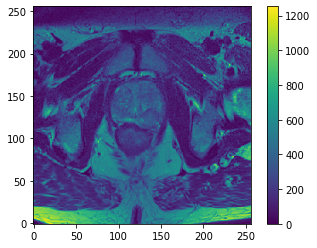

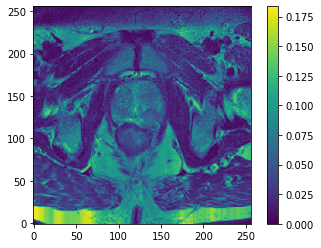

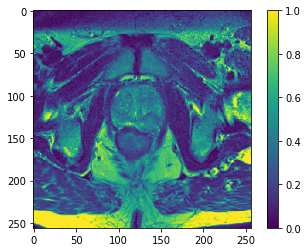

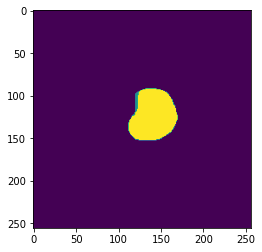

In [ ]:
# plt.imshow(y_train[200,:,:])
fig3 = plt.figure(3)
img = x_train[250,:,:]
plt.imshow(img.T, origin='lower')
plt.colorbar()
img_2 = img
img_2 = np.clip(img_2.copy(), -100, 800)
img_2 = tf.keras.utils.normalize(img_2)
fig4 = plt.figure(4)
plt.imshow(img_2.T, origin='lower')
plt.colorbar()
img = np.clip(img.copy(), -100, 800)
img = img - np.min(img)
img = img/np.max(img)
print(img == img_2)
# img = img.T
# img = np.flip(img)
img = np.rot90(img)
mask = y_train[250,:,:]
print(np.unique(mask))
fig2 = plt.figure(2)
plt.imshow(img)
plt.colorbar()
fig = plt.figure(1)
plt.imshow(mask)


0.0 1.0
0.0 0.17223025786983695


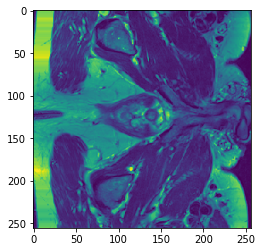

In [ ]:
x_train_test = x_train[0:10,:,:]
img_test = x_train_test[0]
# img_test_norm = tf.keras.utils.normalize(img_test)
print(np.min(img_test),np.max(img_test))
print(np.min(img_test_norm),np.max(img_test_norm))
plt.imshow(img_test_norm)

In [ ]:
x_train = np.expand_dims(x_train, axis=3)
# x_train = normalize(x_train, axis=1)
y_train = np.expand_dims(y_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)

(412, 256, 256, 1)
(412, 256, 256, 1)
(104, 256, 256, 1)
(104, 256, 256, 1)
(302, 256, 256, 1)


[0. 1. 2.]
[0. 1.]


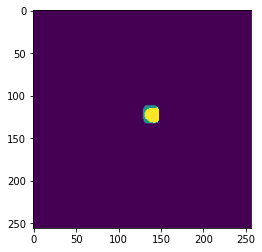

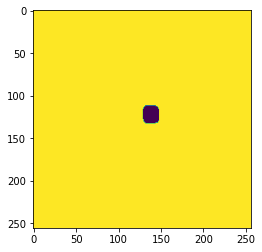

In [ ]:
# from tf.keras.utils import to_categorical
fig1 = plt.figure(1)
print(np.unique(y_train[0]))
plt.imshow(y_train[0,:,:,0])
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=4)
fig2 = plt.figure(2)
print(np.unique(y_train_cat[0]))
plt.imshow(y_train_cat[0,:,:,0])

[0. 1.]
[0. 1.]
[0. 1.]


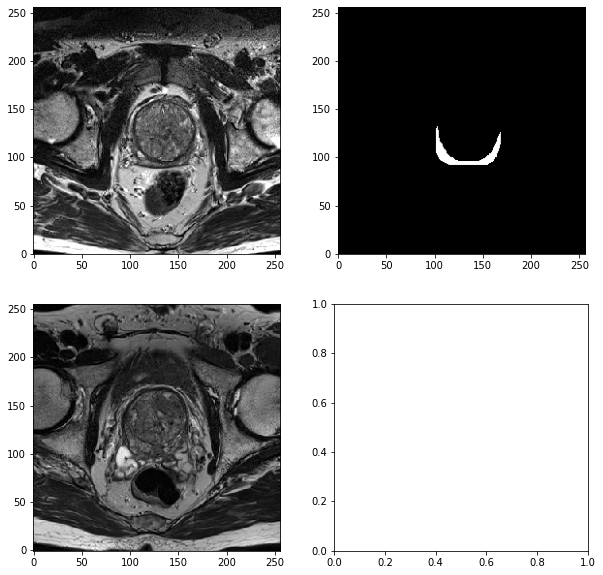

In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=3)
for i in range(3):
  print(np.unique(y_train_cat[200,:,:,i]))

fig, axes = plt.subplots(2,2,figsize=(10,10))
axes[0,0].imshow(x_train[200,:,:,0].T, origin='lower', cmap='gray')
axes[0,1].imshow(y_train_cat[200,:,:,1].T, origin='lower', cmap='gray')
axes[1,0].imshow(x_test[200,:,:,0].T, origin='lower', cmap='gray')

In [ ]:
from sklearn.utils import class_weight
y_train_reshaped = y_train.flatten()
print(y_train_reshaped.shape)
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_reshaped),y_train_reshaped)
print(class_weights)
print(len(np.unique(y_train_reshaped)))

(27000832,)
[ 0.34355598 54.2607046  14.11697488]
3


In [ ]:
np.unique(y_train)

array([0., 1., 2.])

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/AI-Medic/Prostate/semantic_segmentation_model.h5', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]

history = model.fit(x_train,y_train_cat, validation_data=(x_val, y_val_cat), batch_size=16, epochs=5, shuffle=False)
model.save('/content/gdrive/My Drive/AI-Medic/Prostate/25_epochs.hdf5')

Epoch 1/5
26/26 [==============================] - 297s 11s/step - loss: 0.4791 - accuracy: 0.8539 - val_loss: 0.2433 - val_accuracy: 0.9691
Epoch 2/5
26/26 [==============================] - 301s 12s/step - loss: 0.1816 - accuracy: 0.9702 - val_loss: 0.1750 - val_accuracy: 0.9691
Epoch 3/5
26/26 [==============================] - 300s 12s/step - loss: 0.1102 - accuracy: 0.9702 - val_loss: 0.1221 - val_accuracy: 0.9691
Epoch 4/5
26/26 [==============================] - 295s 11s/step - loss: 0.0847 - accuracy: 0.9702 - val_loss: 0.1206 - val_accuracy: 0.9691
Epoch 5/5
26/26 [==============================] - 298s 11s/step - loss: 0.0813 - accuracy: 0.9702 - val_loss: 0.0851 - val_accuracy: 0.9691


In [ ]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/AI-Medic/Prostate/25_epochs.hdf5')

In [ ]:
# preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
# preds_test = model.predict(x_test, verbose=1)

# preds_train_t = (preds_train > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)


test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


10/10 [==============================] - 45s 4s/step


0.32565


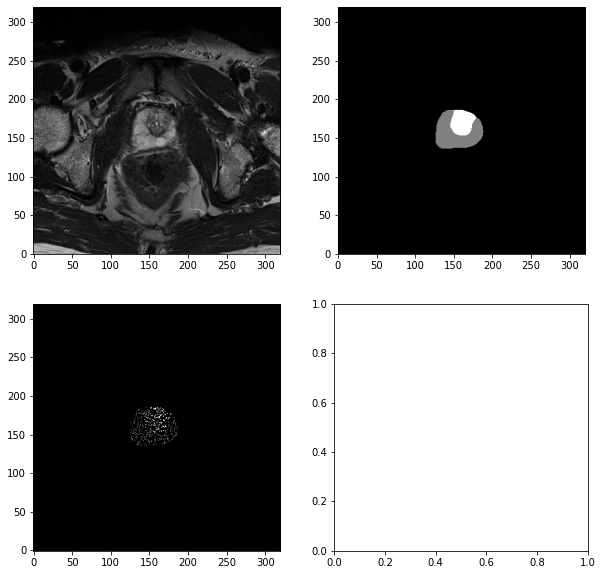

In [ ]:
img_main = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/imagesTr/prostate_17.nii.gz').get_fdata()[:,:,8,0]
label_main = nib.load('/content/gdrive/My Drive/AI-Medic/Prostate/Task05_Prostate/labelsTr/prostate_17.nii.gz').get_fdata()[:,:,8]
label_pred = predicted_img[:,:,0]

fig, axes = plt.subplots(2,2,figsize=(10,10))
axes[0,0].imshow(img_main.T, origin='lower', cmap='gray')
axes[0,1].imshow(label_main.T, origin='lower', cmap='gray')
axes[1,0].imshow(label_pred.T, origin='lower', cmap='gray')

print(round(dice_coeff_loss(label_pred, label_main),5))

TypeError: ignored

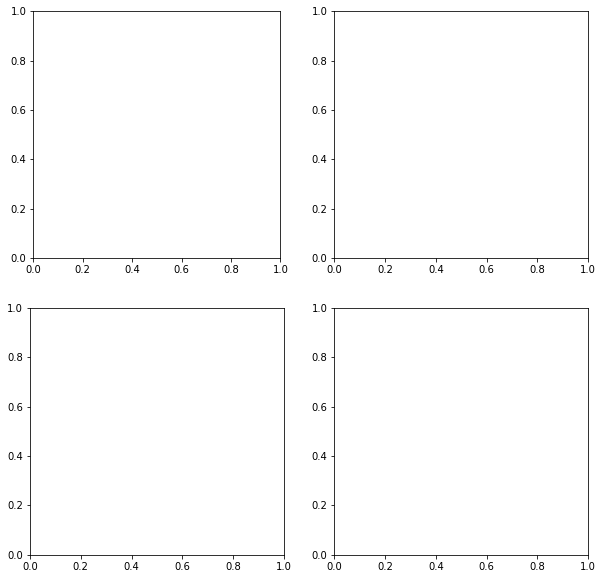

In [ ]:
random.seed(10)
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))


fig, axes = plt.subplots(2,2,figsize=(10,10))
axes[0,0].imshow(x_train[ix].T, origin='lower', cmap='gray')
axes[0,1].imshow(np.squeeze(y_train[ix].T), origin='lower', cmap='gray')
axes[1,0].imshow(np.squeeze(preds_train[ix].T), origin='lower', cmap='gray')

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))

fig, axes = plt.subplots(2,2,figsize=(10,10))
axes[0,0].imshow(x_train[int(x_train.shape[0]*0.9):][ix])
axes[0,0].imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
axes[0,0].imshow(np.squeeze(preds_val_t[ix]))